Collaborative filtering approach: the user is recommended items that people with similar tastes and preferences liked in the past. In another word, this method predicts unknown ratings by using the similarities between users.

In [1]:
# Main Libraries

import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

# Dataset

In [2]:
user = pd.read_csv('data/BX-Users.csv', sep=';', on_bad_lines='skip', encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']

rating = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', on_bad_lines='skip', encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

In [3]:
user.head()

userID                            Location Age
0       2           stockton, california, usa  18
1       3     moscow, yukon territory, russia  \N
2       4           porto, v.n.gaia, portugal  17
3       5  farnborough, hants, united kingdom  \N
4       6       santa monica, california, usa  61

In [4]:
rating.head()

userID        ISBN  bookRating
0  276726  0155061224           5
1  276727  0446520802           0
2  276729  052165615X           3
3  276729  0521795028           6
4  276733  2080674722           0

In [5]:
df = pd.merge(user, rating, on='userID', how='inner')

df.drop(['Location', 'Age'], axis=1, inplace=True)

df.head()

userID        ISBN  bookRating
0       2  0195153448           0
1       7   034542252           0
2       8  0002005018           5
3       8  0060973129           0
4       8  0374157065           0

In [6]:
df.shape

(1149779, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149779 entries, 0 to 1149778
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userID      1149779 non-null  int64 
 1   ISBN        1149779 non-null  object
 2   bookRating  1149779 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [8]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::200000, :])  # start from the beginning; end at the last row; selec every 200,000th row

Dataset shape: (1149779, 3)
-Dataset examples-
         userID        ISBN  bookRating
0             2  0195153448           0
200000    48494  0871233428           0
400000    98391  0670032549          10
600000   147513  0470832525           5
800000   196502  0590431862           0
1000000  242157  0732275865           0


# Exploratory Data Analysis

### Ratings Distribution

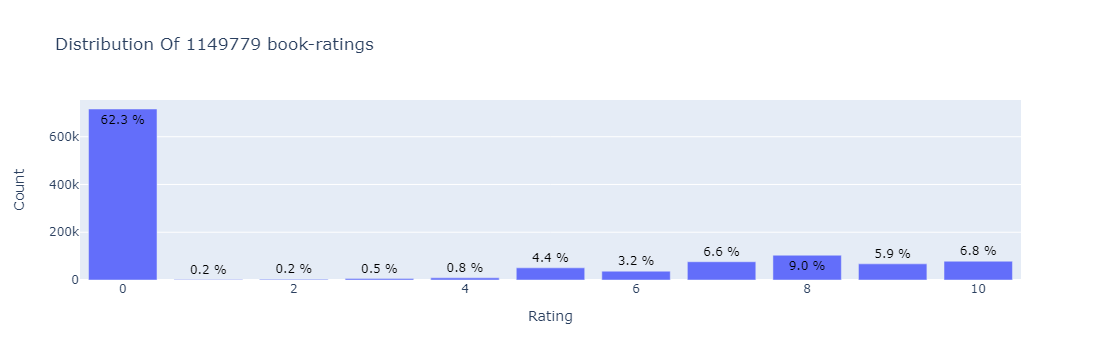

In [9]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


data = df['bookRating'].value_counts().sort_index(ascending=False)

trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )

# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can see that over 62% of all ratings in the data are 0, and very few ratings are 1 or 2, or 3, low rating books mean they are generally really bad.

### Ratings Distribution By Book

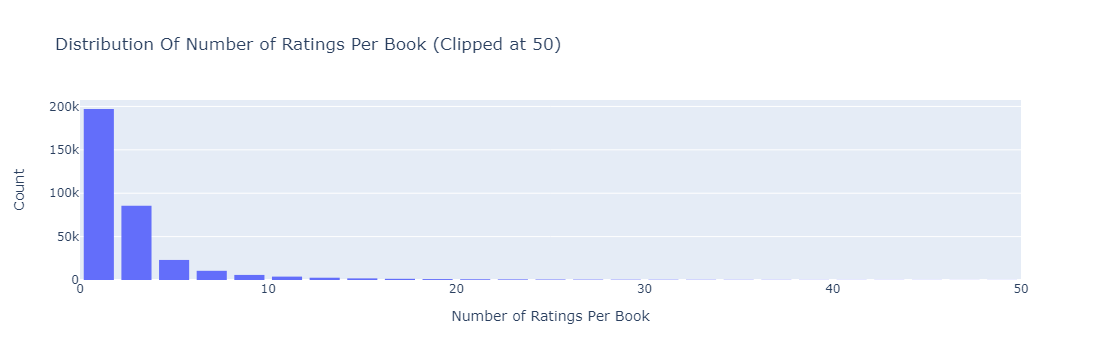

In [10]:
# Number of ratings per book
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [11]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

ISBN  bookRating
247408  0971880107        2502
47371   0316666343        1295
83359   0385504209         883
9637    0060928336         732
41007   0312195516         723
101670  044023722X         647
166705  0679781587         639
28153   0142001740         615
166434  067976402X         614
153620  0671027360         586

In [12]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=True)[:10]

ISBN  bookRating
170277  0688009328           1
212226  0817221999           1
212227  0817224181           1
212228  0817230254           1
212229  0817230300           1
212230  0817234047           1
212232  0817235027           1
212234  0817242287           1
212235  0817250557           1
212236  0817256016           1

Most of the books in the data received less than 5 ratings, and very few books have many ratings, although the most rated book has received 2,502 ratings.

### Ratings Distribution By User

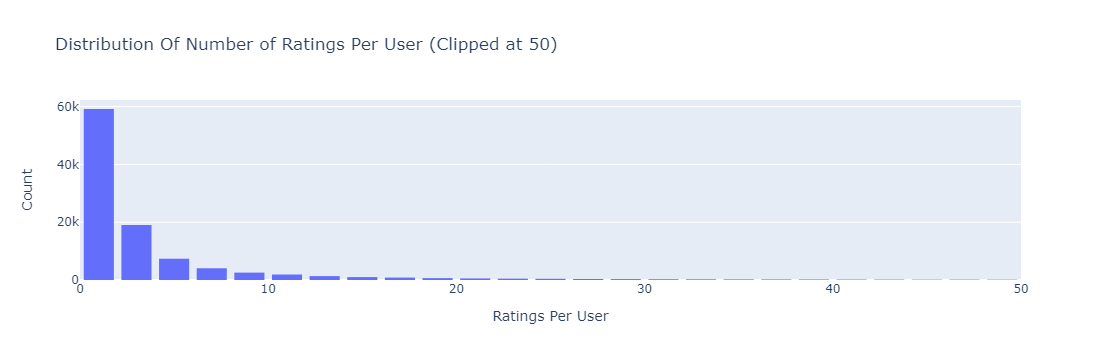

In [13]:
# Number of ratings per user
data = df.groupby('userID')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [14]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

userID  bookRating
4213     11676       13602
74815   198711        7550
58113   153662        6109
37356    98391        5891
13576    35859        5850
80185   212898        4785
105110  278418        4533
28884    76352        3367
42037   110973        3100
88584   235105        3067

Most of the users in the data gave less than 5 ratings, and not many users gave many ratings, although the most productive user have given 13,602 ratings..

To reduce the dimensionality of the data set, and avoid running into “memory error”, we will filter out rarely rated books and rarely rating uss.



In [15]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]

print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149779, 3)
The new data frame shape:	(140516, 3)


# Surprise
To load a dataset from a pandas dataframe, we will use the `load_from_df()` method, we will also need a `Reader` object, and the `rating_scale` parameter must be specified. The dataframe must have three columns, corresponding to the `user ids`, the `item ids`, and the `ratings` in this order. Each row thus corresponds to a given rating.

In [16]:
reader = Reader(rating_scale=(0, 9))

data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

With the Surprise library, we will benchmark the following algorithms

## Basic algorithms
#### NormalPredictor
NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.
#### BaselineOnly
BasiclineOnly algorithm predicts the baseline estimate for given user and item.
## k-NN algorithms
#### KNNBasic
KNNBasic is a basic collaborative filtering algorithm.
#### KNNWithMeans
KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.
#### KNNWithZScore
KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.
#### KNNBaseline
KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

## Matrix Factorization-based algorithms
#### SVD
SVD algorithm is equivalent to [Probabilistic Matrix Factorization](http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)
#### SVDpp
The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.
#### NMF
NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

## Slope One
Slope One is a straightforward implementation of the [SlopeOne algorithm](https://arxiv.org/abs/cs/0702144)

## Co-clustering
Co-clustering is a collaborative filtering algorithm based on co-clustering

In [17]:
# Create an empty list
algorithm_result = []

# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), BaselineOnly(), CoClustering()]:
    
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = pd.concat([tmp, pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm'])])
    
    algorithm_result.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


We use `rmse` as our accuracy metric for the predictions.

In [18]:
# Create a datframe with results of the grid search
pd.DataFrame(algorithm_result).set_index('Algorithm').sort_values('test_rmse') 

test_rmse   fit_time  test_time
Algorithm                                       
BaselineOnly      3.376224   0.245751   0.458291
CoClustering      3.462514   3.737888   0.512124
SlopeOne          3.478305   0.903959   4.508922
KNNWithMeans      3.488660   1.128018   5.914181
KNNBaseline       3.493844   1.206617   6.453997
SVD               3.541827   0.483753   0.157347
KNNBasic          3.727981   0.967016   5.471012
SVDpp             3.785159  22.729714   8.786564
NMF               3.850498   2.763200   0.547079
NormalPredictor   4.676455   0.168390   0.458113

*BaselineOnly* algorithm gave us the best rmse, therefore, we will train and predict with BaselineOnly and use Alternating Least Squares (ALS).

In [19]:
print('Using ALS')

bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }

algo = BaselineOnly(bsl_options=bsl_options)

cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([3.38027757, 3.3776479 , 3.3675489 ]),
 'fit_time': (0.14939641952514648, 0.16273736953735352, 0.15581941604614258),
 'test_time': (0.2296593189239502, 0.41619229316711426, 0.4158599376678467)}

We use the `train_test_split()` to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. We’ll then use the `fit()` method which will train the algorithm on the trainset, and the `test()` method which will return the predictions made from the testset

In [20]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3552


3.35516060811551

In [21]:
# dump.dump('./dump_file', predictions, algo)
# predictions, algo = dump.load('./dump_file')

In [22]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


To inspect our predictions in details, we are going to build a pandas data frame with all the predictions.

In [23]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

df.head()

uid         iid  rui       est                    details   Iu   Ui  \
0  249628  0373218036  8.0  2.181858  {'was_impossible': False}   65   67   
1    2977  0385722206  0.0  2.406720  {'was_impossible': False}   24  132   
2  170861  0743431030  0.0  0.414478  {'was_impossible': False}   36   24   
3   86033  0971880107  0.0  1.340233  {'was_impossible': False}    3  644   
4  225810  0373483503  0.0  0.254323  {'was_impossible': False}  212   57   

        err  
0  5.818142  
1  2.406720  
2  0.414478  
3  1.340233  
4  0.254323

In [24]:
best_predictions = df.sort_values(by='err')[:10]

worst_predictions = df.sort_values(by='err')[-10:]

In [25]:
best_predictions

uid         iid  rui  est                    details   Iu  Ui  err
25410  102967  0425136191  0.0  0.0  {'was_impossible': False}  381  39  0.0
33388  186570  0425151875  0.0  0.0  {'was_impossible': False}  100  48  0.0
24728   98741  0671793535  0.0  0.0  {'was_impossible': False}  229  33  0.0
6480   242361  002026478X  0.0  0.0  {'was_impossible': False}   59  40  0.0
18377   87746  0553574574  0.0  0.0  {'was_impossible': False}  169  58  0.0
27658  212898  0425161722  0.0  0.0  {'was_impossible': False}  194  36  0.0
30047  190741  0446365505  0.0  0.0  {'was_impossible': False}   44  50  0.0
15310  269719  155166674X  0.0  0.0  {'was_impossible': False}  103  40  0.0
28062   49109  0061096113  0.0  0.0  {'was_impossible': False}   93  36  0.0
29528  113519  0440235774  0.0  0.0  {'was_impossible': False}  215  25  0.0

The above are the best predictions, and they are not lucky guesses. Because Ui is anywhere between 22 to 477, they are not really small, meaning that significant number of users have rated the target book.

In [26]:
worst_predictions

uid         iid   rui       est                    details   Iu  \
4225    14521  0440222656  10.0  0.300540  {'was_impossible': False}  173   
31676  107453  0671642561  10.0  0.188182  {'was_impossible': False}   32   
5590   263460  0440236851  10.0  0.126791  {'was_impossible': False}   55   
18521   81045  0515120278  10.0  0.107339  {'was_impossible': False}   49   
17496  201768  0671016776  10.0  0.019602  {'was_impossible': False}   49   
9532    91832  0440241537  10.0  0.007459  {'was_impossible': False}   94   
33200   24921  0440236665  10.0  0.000000  {'was_impossible': False}   79   
34149   24921  0671749412  10.0  0.000000  {'was_impossible': False}   79   
11455  156214  0446365505  10.0  0.000000  {'was_impossible': False}   33   
7573    55548  0553278398  10.0  0.000000  {'was_impossible': False}  138   

        Ui        err  
4225   183   9.699460  
31676   30   9.811818  
5590    37   9.873209  
18521   24   9.892661  
17496   20   9.980398  
9532    86   9.992541  
33200   22  10.000000  
34149   35  10.000000  
11455   50  10.000000  
7573    26  10.000000

In [27]:
df_new.loc[df_new['ISBN'] == '0345347951']['bookRating'].describe()

count    34.000000
mean      1.970588
std       3.737487
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      10.000000
Name: bookRating, dtype: float64

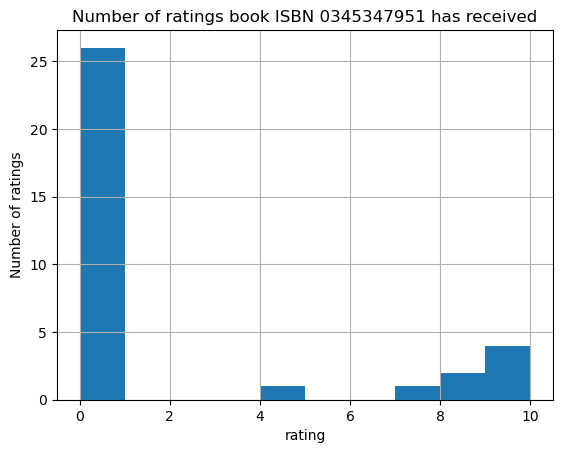

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

df_new.loc[df_new['ISBN'] == '0345347951']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 0345347951 has received')
plt.show();

It turns out, most of the ratings this book received was "0", in another word, most of the users in the data rated this book "0", only very few users rated "10". Same with the other predictions in "worst predictions" list. It seems that for each prediction, the users are some kind of outsiders.